# Step_5_Cost_when_training_ML_algorithm

## Misclassification cost as part of training

There are 2 ways to introduce cost into the learning function :

- Defining the **class_weight** parameter for those estimators that allow it, when we set the estimator
- Passing a **sample_weight** vector with the weights for every single observation, when we fit the estimator.


With both the **class_weight** parameter or the **sample_weight** vector, we indicate that the loss function should be modified to accommodate the class imbalance and the cost attributed to each misclassification.

## parameters

**class_weight**: can take 'balanced' as argument, in which case it will use the balance ratio as weight. Alternatively, it can take a dictionary with {class: penalty}, pairs. In this case, it penalizes mistakes in samples of class[i] with class_weight[i].

So if class_weight = {0:1, and 1:10}, misclassification of observations of class 1 are penalized 10 times more than misclassification of observations of class 0.

**sample_weight** is a vector of the same length as y, containing the weight or penalty for each individual observation. In principle, it is more flexible, because it allows us to set weights to the observations and not to the class as a whole. 

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np


#show cells with width as long as screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#Hide warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.options.display.max_columns = None

from sklearn.linear_model import LogisticRegression

#metric
from sklearn.metrics import roc_auc_score, plot_roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

Classifiers that support class_weight

In [2]:
# THIS CELL WILL NOT WORK WITH SKLEARN VERSION > 0.24

from sklearn.utils.testing import all_estimators

estimators = all_estimators(type_filter='classifier')

for name, class_ in estimators:
    try:
        if hasattr(class_(), 'class_weight'):
            print(name)
    except:
        pass

DecisionTreeClassifier
ExtraTreeClassifier
ExtraTreesClassifier
LinearSVC
LogisticRegression
LogisticRegressionCV
NuSVC
PassiveAggressiveClassifier
Perceptron
RandomForestClassifier
RidgeClassifier
RidgeClassifierCV
SGDClassifier
SVC


# 2. Load data

This data has been generated in the notebook: step_2_Preprocessing_data

In [3]:
X_train = pd.read_excel('X_train_step_2.xlsx', engine='openpyxl').values
X_test =  pd.read_excel('X_test_step_2.xlsx', engine='openpyxl').values
y_train = pd.read_excel('y_train_step_2.xlsx', engine='openpyxl').values
y_test = pd.read_excel('y_test_step_2.xlsx', engine='openpyxl').values

# 3. Modeling

# 3.1 Logistic Regression

### a) Class_weight

We use the parameters whish present the best results obtained on the step 3 notebooks

In [4]:
def run_Logit(X_train, X_test, y_train, y_test, class_weight):
    
    # weights introduced here
    logit = LogisticRegression(
        penalty='l1',
        solver='saga',
        random_state=0,
        max_iter=10,
        n_jobs=4,
        class_weight=class_weight # weights / cost
    )
    
    logit.fit(X_train, y_train)
    
    
     #model prediction
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, logit.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, logit.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    return cf_matrix, FPR, FNR

1. We evaluate performance of the algorithm using imbalanced dataset

In [6]:
run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          class_weight=None)

Train set
Logistic Regression roc-auc: 0.716487556561086
Test set
Logistic Regression roc-auc: 0.6300904977375565


(array([[68,  0],
        [13,  0]], dtype=int64),
 0.0,
 1.0)

As expected, the algorithm does not predict any TP

2. We evaluate performance of the algorithm using balance class_weight (same number of samples)

In [7]:
run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          class_weight='balanced')

Train set
Logistic Regression roc-auc: 0.7429298642533937
Test set
Logistic Regression roc-auc: 0.6527149321266968


(array([[42, 26],
        [ 5,  8]], dtype=int64),
 0.38235294117647056,
 0.38461538461538464)

We noticed a great improvement

3. We evaluate performance of the algorithm changing the class_weight importance ratios

In [12]:
run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          class_weight={0:1, 1:7})

Train set
Logistic Regression roc-auc: 0.7643523755656109
Test set
Logistic Regression roc-auc: 0.6153846153846154


(array([[37, 31],
        [ 4,  9]], dtype=int64),
 0.45588235294117646,
 0.3076923076923077)

By increasing the ratio and giving more importance to the minority class, we improve the value of FNR, however the value of FPR increases.

***Conclusion*: on one hand The best results is balance class_weight

In [22]:
thresholds = np.linspace(0, 1, 100)
fpr_ls = []
fnr_ls = []

# obtain probabilities
logit = LogisticRegression(
        penalty='l1',
        solver='saga',
        random_state=0,
        max_iter=10,
        n_jobs=4,
        class_weight='balance' # weights / cost
    )
    
logit.fit(X_train, y_train)


# obtain probabilities
probs = logit.predict_proba(X_test)[:,1]

for threshold in thresholds:   
    
    # obtain class prediction based on threshold
    preds = np.where(probs>=threshold, 1, 0)
    
    # obtain confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds, labels=[0,1]).ravel()
    
    #  obtain FRP and FNR
    FPR = fp / (tn + fp)
    FNR =  fn / (tp + fn)

    fpr_ls.append(FPR)
    fnr_ls.append(FNR)
    
    metrics = pd.concat([
    pd.Series(fpr_ls),
    pd.Series(fnr_ls)], axis=1)

metrics.columns = ['fpr', 'fnr']
metrics.index = thresholds

Text(0.5, 1.0, 'FPR and FNR vs Discriminant Threshold')

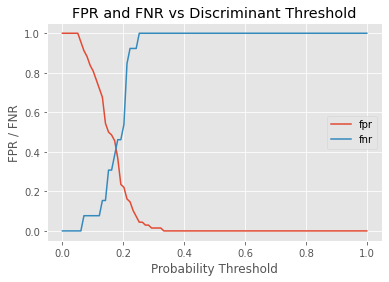

In [23]:
metrics.plot()
plt.xlabel('Probability Threshold')
plt.ylabel('FPR / FNR')
plt.title('FPR and FNR vs Discriminant Threshold')

### b) sample_weight

In [ ]:
LG + sample_weight

In [24]:
def run_Logit(X_train, X_test, y_train, y_test, sample_weight):
    
    logit = LogisticRegression(
        penalty='l2',
        solver='newton-cg',
        random_state=0,
        max_iter=10,
        n_jobs=4,
    )
    
    # costs are passed here
    logit.fit(X_train, y_train, sample_weight=sample_weight)

         #model prediction
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, logit.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, logit.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    return cf_matrix, FPR, FNR

1. We evaluate performance of the algorithm using imbalanced dataset

In [26]:
run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          sample_weight=None)

Train set
Logistic Regression roc-auc: 0.8038037330316743
Test set
Logistic Regression roc-auc: 0.5373303167420815


(array([[68,  0],
        [13,  0]], dtype=int64),
 0.0,
 1.0)

2. We evaluate performance of the algorithm using a cost of 99 to observations of minority class and for majority 1

In [34]:
run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          sample_weight=[np.where(y_train==1,99,1)])

ValueError: Found input variables with inconsistent numbers of samples: [14580, 324]

In [ ]:
RF y DT